<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Optimization trading strategies


<br>


📈Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

# Import strategy returns

In [ ]:
ml_returns = pd.read_csv("ML.csv", index_col="time", parse_dates=True)

In [ ]:
ta_returns = pd.read_csv("TA.csv", index_col="time", parse_dates=True).dropna()

# Portfolio optimization

In [ ]:
from scipy.optimize import minimize
def SR_criterion(weight, returns): 
  """ 
  ------------------------------------------------------------------------------
  | Output: Opposite Sortino ratio to do a mimization                          |
  ------------------------------------------------------------------------------
  | Inputs: -Weight (type ndarray numpy): Wheight for portfolio                |
  |         -returns (type dataframe pandas): Returns of stocks                |
  ------------------------------------------------------------------------------
  """
  pf_return = returns.values.dot(weight)
  mu = np.mean(pf_return) 
  sigma = np.std(pf_return[pf_return<0])
  Sortino = -mu/sigma
  return Sortino



# Compute the number of the strategies
n = ml_returns.shape[1]

# Initialisation weight value
x0 = np.zeros(n)+(1/n)

# Optimization constraints problem
cons=({'type':'eq', 'fun':lambda x:sum(abs(x))-1})


# Put the bounds
Bounds = [(0.05,0.30) for i in range(0,n)]

# Optimization problem solving
res_SR = minimize(SR_criterion, x0, method="SLSQP", args=(ml_returns.dropna()), bounds=Bounds, constraints=cons, options={'disp':False})

# Result for computations
X_SR = res_SR.x

np.round(X_SR,3)

array([0.05, 0.3 , 0.05, 0.05, 0.05, 0.1 , 0.3 , 0.05, 0.05])

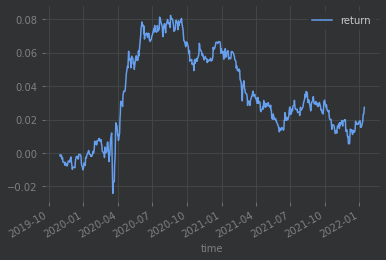

In [ ]:
sr = np.multiply(ml_returns, X_SR).sum(axis=1)
sr = pd.DataFrame(sr, columns=["return"])
sr.cumsum().plot()

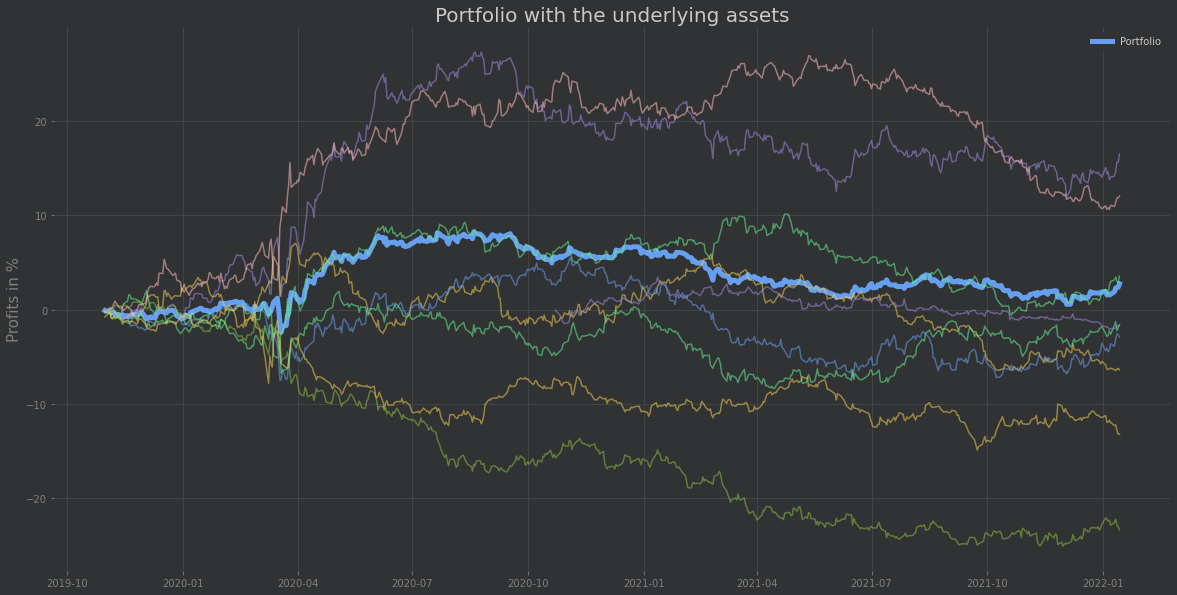

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(sr.cumsum()*100, linewidth=5, label="Portfolio")
plt.plot(ml_returns.cumsum()*100, alpha=0.55)

plt.title("Portfolio with the underlying assets", size=20)
plt.ylabel("Profits in %", size=15)

plt.legend()
plt.show()

# Risk management example

<p><img alt="Colaboratory logo"  src="https://www.quantreo.com/wp-content/uploads/2022/01/Capture-decran-2022-01-13-a-18.33.13.png" align="left" hspace="10px" vspace="0px"></p>


In [ ]:
def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown

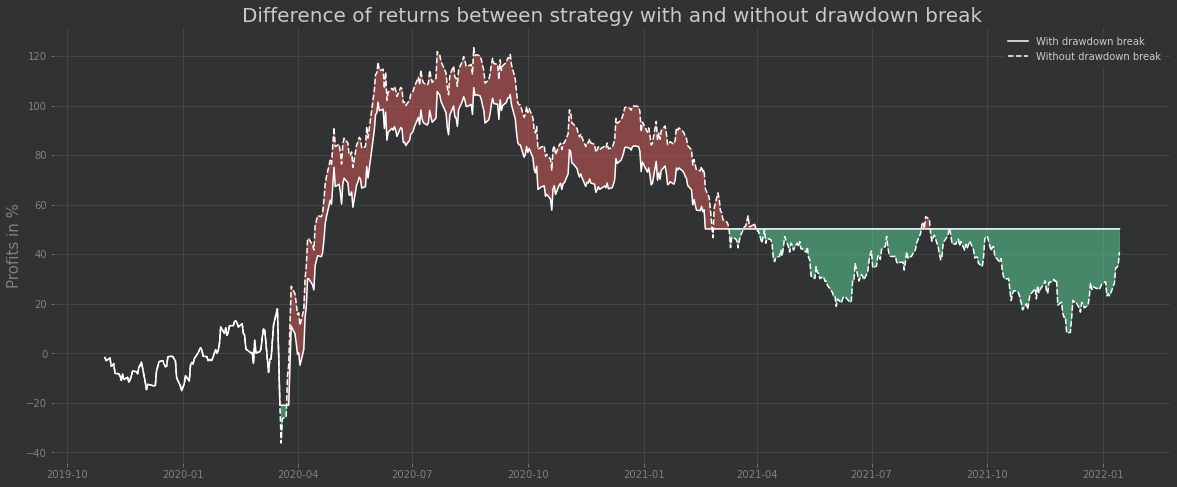

In [ ]:
# Portfolio creation
leverage = 15
sr = np.multiply(ml_returns, X_SR).sum(axis=1)
ddb = pd.DataFrame(sr, columns=["return"])*leverage

# Drawdown computation
ddb["drawdown"] = drawdown_function(ddb["return"])

# If the drawdown falls below the DDB threshold we stop the strategy TOMORROW
ddb.loc[ddb["drawdown"].shift(1)<-0.015*leverage, "return"] = 0


# Display
with_ddb = ddb["return"].cumsum()*100
without_ddb = sr.cumsum()*leverage*100

plt.figure(figsize=(20,8))
plt.plot(with_ddb, "-", color="white")
plt.plot(without_ddb,"--", color="white")

plt.fill_between(with_ddb.index, with_ddb, without_ddb,with_ddb<without_ddb, color= "#CE5757", alpha=0.55)
plt.fill_between(with_ddb.index, with_ddb, without_ddb,with_ddb>without_ddb, color= "#57CE95", alpha=0.55)

plt.legend(["With drawdown break", "Without drawdown break"])
plt.ylabel("Profits in %", size=15)
plt.title("Difference of returns between strategy with and without drawdown break", size=20)

plt.show()

# Individual drawdown break


In [ ]:
# Create empty dataframe
ddb_ret = pd.DataFrame()

ddb_threshold = 0.06
for name in ml_returns.columns:
  
  # Take the returns
  ret = ml_returns[[name]]
  
  # Rename
  ret.columns = ["return"]

  # Compute the drawdown
  ret["drawdown"] = drawdown_function(ret["return"])

  # Add the ddb
  ret.loc[ret["drawdown"].shift(1)<-ddb_threshold] = 0

  # Rename
  ret.columns = [name, "dd"]

  ddb_ret[name] = ret[name]

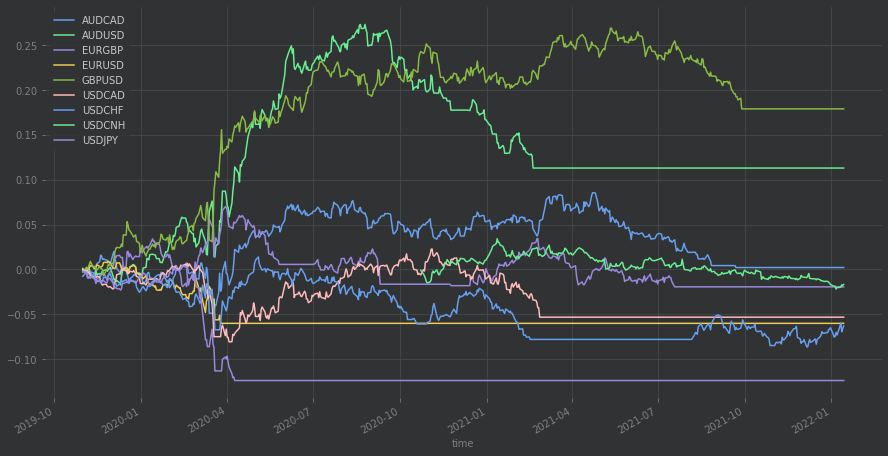

In [ ]:
ddb_ret.cumsum(axis=0).plot(figsize=(15,8))

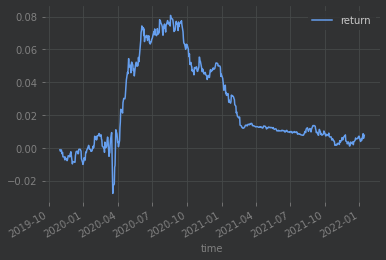

In [ ]:
# Plot DDB returns
sr = np.multiply(ddb_ret, X_SR).sum(axis=1)
sr = pd.DataFrame(sr, columns=["return"])
sr.cumsum().plot()

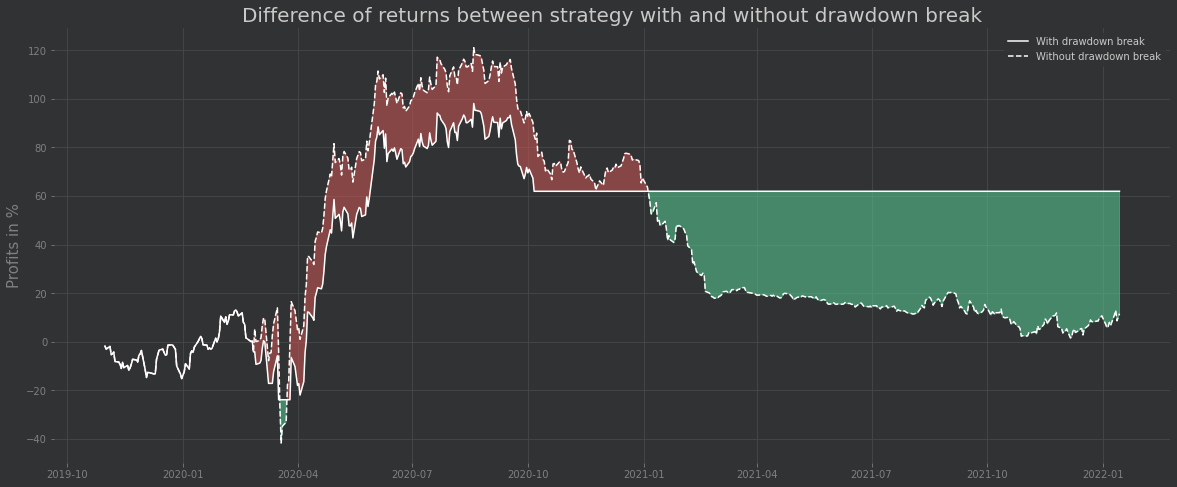

In [ ]:
# Portfolio creation
leverage = 15
sr = np.multiply(ddb_ret, X_SR).sum(axis=1)
ddb = pd.DataFrame(sr, columns=["return"])*leverage

# Drawdown computation
ddb["drawdown"] = drawdown_function(ddb["return"])

# If the drawdown falls below the DDB threshold we stop the strategy TOMORROW
ddb.loc[ddb["drawdown"].shift(1)<-0.01 * leverage, "return"] = 0


with_ddb = ddb["return"].cumsum()*100
without_ddb = sr.cumsum()*leverage*100

plt.figure(figsize=(20,8))
plt.plot(with_ddb, "-", color="white")
plt.plot(without_ddb,"--", color="white")

plt.fill_between(with_ddb.index, with_ddb, without_ddb,with_ddb<without_ddb, color= "#CE5757", alpha=0.55)
plt.fill_between(with_ddb.index, with_ddb, without_ddb,with_ddb>without_ddb, color= "#57CE95", alpha=0.55)

plt.legend(["With drawdown break", "Without drawdown break"])
plt.ylabel("Profits in %", size=15)
plt.title("Difference of returns between strategy with and without drawdown break", size=20)

plt.show()